In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping

def preprocess_data(data):
    # Unpack data
    X_train_valid = data['X_train_valid']
    y_train_valid = data['y_train_valid']
    X_test = data['X_test']
    y_test = data['y_test']

    # One-hot Encoding for y data
    encoder = LabelBinarizer()
    y_train_valid = encoder.fit_transform(y_train_valid)
    y_test = encoder.fit_transform(y_test)

    # Splitting training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

    total_y_train = y_train
    total_y_val = y_val
    total_y_test = y_test

    # Trim
    X_train = X_train[:,:,0:800]
    X_val = X_val[:,:,0:800]
    X_test = X_test[:,:,0:800]

    # Maxpooling
    total_X_train = np.max(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 4), axis=3)
    total_X_val = np.max(X_val.reshape(X_val.shape[0], X_val.shape[1], -1, 4), axis=3)
    total_X_test = np.max(X_test.reshape(X_test.shape[0], X_test.shape[1], -1, 4), axis=3)

    # Validation and Test Data augmentation stops here (reshaping purposes)
    # Averaging and Subsampling below only apply to Training Data

    # Average every 4 time dumps
    X_train_average = np.mean(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 4), axis=3)
    X_train_average += np.random.normal(0.0, 0.5, X_train_average.shape)
    total_X_train = np.vstack((total_X_train, X_train_average))
    total_y_train = np.vstack((total_y_train, y_train))

    # Subsample every 4 time dumps
    for i in range(0, 4):
        X_train_subsample = X_train[:,:,i::4] + np.random.normal(0.0, 0.5, X_train[:,:,i::4].shape)
        total_X_train = np.vstack((total_X_train, X_train_subsample))
        total_y_train = np.vstack((total_y_train, y_train))

    return {'total_X_train': total_X_train, 'total_X_val': total_X_val, 'total_X_test': total_X_test, 'total_y_train': total_y_train, 'total_y_val': total_y_val, 'total_y_test': total_y_test}

# Load original data
data = dict()
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy")
person_test = np.load("data/person_test.npy")
data['X_train_valid'] = X_train_valid
data['y_train_valid'] = y_train_valid
data['X_test'] = X_test
data['y_test'] = y_test
data['person_train_valid'] = person_train_valid
data['person_test'] = person_test
preprocessed_data = preprocess_data(data)

# Load preprocessed data
X_train = preprocessed_data['total_X_train']
y_train = preprocessed_data['total_y_train']
X_val = preprocessed_data['total_X_val']
y_val = preprocessed_data['total_y_val']
X_test = preprocessed_data['total_X_test']
y_test = preprocessed_data['total_y_test']
X_train = np.transpose(X_train, (0, 2, 1))
X_val = np.transpose(X_val, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

In [15]:
RNN = Sequential()

RNN.add(GRU(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.03)))
RNN.add(Flatten())
RNN.add(Dropout(0.5))
RNN.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

RNN.compile(optimizer=optimizer, loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

RNN.summary()
print("Model compiled.")

/Users/wonjinlee/anaconda3/envs/ECEC147/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 200, 16)        │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │        12,804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,724 (57.52 KB)

 Trainable params: 14,724 (57.52 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled.


Epoch 1/50


/Users/wonjinlee/anaconda3/envs/ECEC147/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.2848 - loss: 2.8264 - val_accuracy: 0.3546 - val_loss: 2.2272
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.4066 - loss: 2.2629 - val_accuracy: 0.4303 - val_loss: 2.0544
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - accuracy: 0.5159 - loss: 1.9177 - val_accuracy: 0.4468 - val_loss: 1.9412
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.5942 - loss: 1.6669 - val_accuracy: 0.4752 - val_loss: 1.8319
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.6313 - loss: 1.5086 - val_accuracy: 0.4657 - val_loss: 1.7438
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.6847 - loss: 1.3358 - val_accuracy: 0.4941 - val_loss: 1.6618
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.7069 - loss: 1.2377 - val_accuracy: 0.5225 - val_loss: 1.6067
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.7338 - loss: 1.1476 - val_accuracy: 0.5201 - val

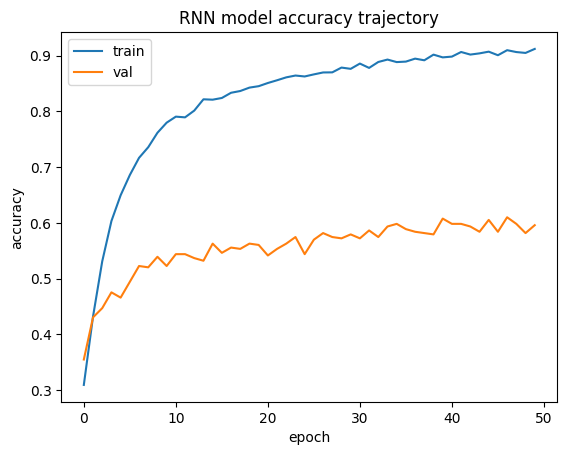

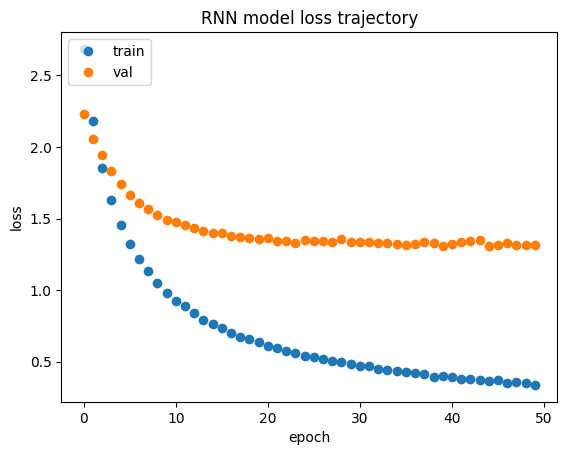

In [16]:
RNN_results = RNN.fit(X_train, y_train, epochs=50, batch_size=640, validation_data=(X_val, y_val), shuffle=True, verbose=1, callbacks=[early_stopping])

# Plotting accuracy trajectory
plt.plot(RNN_results.history['accuracy'])
plt.plot(RNN_results.history['val_accuracy'])
plt.title('RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(RNN_results.history['loss'],'o')
plt.plot(RNN_results.history['val_loss'],'o')
plt.title('RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
## Testing the model
RNN_score = RNN.evaluate(X_test, y_test, verbose=0)
print('Test accuracy of the RNN model:',RNN_score[1])

Test accuracy of the RNN model: 0.6365688443183899


In [18]:
RNN.save('RNN_best.h5')